In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim.lr_scheduler import StepLR 
from torchinfo import summary
from tqdm.notebook import tqdm

import mlflow
import mlflow.pytorch

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print(f"Using {device} device")

Using cpu device


In [3]:
data_dir = "C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Will read traindata from", train_dir)
print("And the test data from", test_dir)

Will read traindata from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//train
And the test data from C://Users//DELL//Desktop//endtoend-mlops//data//raw//Covid19-dataset//test


In [4]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [5]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [6]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [7]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
            )
   ]
    )

print(type(transform_normalized))
print("-------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [8]:
normalized_dataset = datasets.ImageFolder(root=train_dir, transform=transform_normalized)

print('Length of dataset:', len(normalized_dataset))

Length of dataset: 251


In [9]:
g = torch.Generator()
g.manual_seed(42)

In [10]:
train_dataset, val_dataset = random_split(normalized_dataset, [0.8, 0.2], generator=g)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_normalized)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))
print("Length of test dataset:", len(test_dataset))

Length of training dataset: 201
Length of validation dataset: 50
Length of test dataset: 66


In [11]:
percent_train = np.round(100*len(train_dataset)/ len(normalized_dataset),2)
percent_val = np.round(100*len(val_dataset) / len(normalized_dataset), 2)


print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val} of full data")

Train data is 80.08% of full data
Validation data is 19.92 of full data


In [12]:
def class_counts(dataset):
    ds = dataset.dataset if isinstance(dataset, Subset) else dataset
    counts = Counter(lbl for _, lbl in tqdm(dataset, desc="Counting classes"))
    return pd.Series({cls: counts[idx] for cls, idx in ds.class_to_idx.items()})

In [13]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions

Counting classes:   0%|          | 0/201 [00:00<?, ?it/s]

Covid              94
Normal             56
Viral Pneumonia    51
dtype: int64

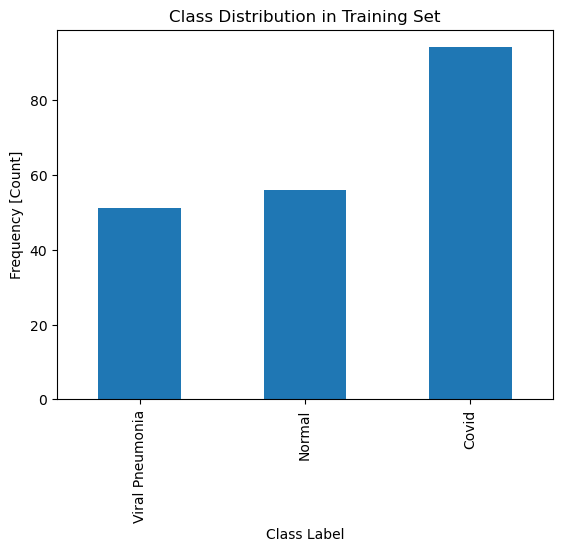

In [14]:
train_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Training Set");

Counting classes:   0%|          | 0/50 [00:00<?, ?it/s]

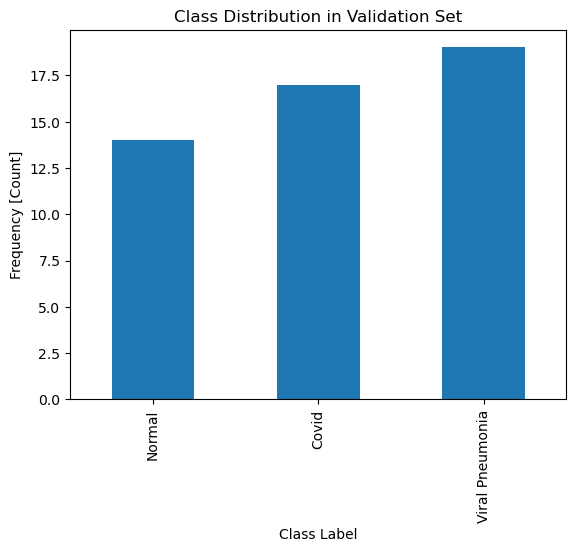

In [15]:
validation_class_distributions = class_counts(val_dataset)

validation_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Validation Set");

Counting classes:   0%|          | 0/66 [00:00<?, ?it/s]

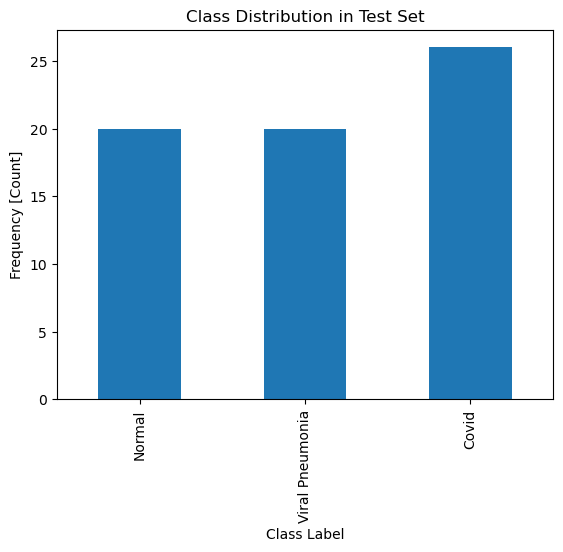

In [16]:
test_class_distributions = class_counts(test_dataset)

test_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Test Set");

In [17]:
# --- Hyperparameters ---
batch_size = 32
epochs_to_train = 23
initial_learning_rate = 1e-3
weight_decay = 1e-4
step_size = 4      # decay every 4 epochs
gamma = 0.2        # reduce LR by 0.2
loss_fn = nn.CrossEntropyLoss()
height=224
width=224

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

print(type(train_loader))  
print(type(val_loader))    
print(type(test_loader))   

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [19]:
# Load ResNet-18 with pretrained weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

in_features = model.fc.in_features

# 3. Replace the FC layer with a new one for 3 classes
model.fc = nn.Linear(in_features, 3)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
for params in model.parameters():
    params.requires_grad = False
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

## Checking the Size of I/O features

In [22]:
in_feat = model.fc.in_features
print(in_feat)

512


In [23]:
out_feat = model.fc.out_features
print(out_feat)

3


In [24]:
modified_last_layer = nn.Sequential(
    nn.Linear(in_feat, 253),  
    nn.ReLU(),
    nn.Linear(253, out_feat)
)

model.fc = modified_last_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)

print(loss_fn)
print("-------------------")
print(optimizer)

CrossEntropyLoss()
-------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [26]:
model.to(device)
print(next(model.parameters()).device)

cpu


In [27]:
# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size = step_size,
    gamma = gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [28]:
summary(model, input_size = (batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [29]:
def early_stopping(validation_loss, best_val_loss, counter):
    
    stop = False
    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1
    
    # check if counter is >= patience (5 epoch in our case)
    # set stop variable accordingly
    if counter >= 5:
        stop = True
        
    return counter, stop

In [30]:
def checkpointing(validation_loss, best_val_loss, model, opitimizer, save_path):
    
    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation{validation_loss:.4f}")

In [31]:
from training import score, train_epoch

In [32]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,  
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    # Track best model for checkpointing/early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0
    stop = False
    
    print("Model evaluation before start of training...")

    # Initial evaluation
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)   
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")
        
        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate validation results
        val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Logging
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.2f}%")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        # Log learning rate
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()
            
        # Checkpointing
        if checkpoint_path:
            checkpointing(val_loss, best_val_loss, model, optimizer, checkpoint_path)
            
        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                val_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
                
    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )


In [33]:
# --- MLflow step: start experiment and log hyperparameters ---
from ml_flow import init_experiment, log_params

if mlflow.active_run() is not None:
    mlflow.end_run()

run = init_experiment("covid_chest_classification")
hyperparams = {
    "batch_size": batch_size,
    "epochs": epochs_to_train,
    "optimizer": "Adam",
    "learning_rate": 1e-3,
    "weight_decay": weight_decay,
    "scheduler_step_size": step_size,
    "scheduler_gamma": gamma
}
log_params(hyperparams)

In [34]:
# Call training function and store results
train_results = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs_to_train,
    device=device,
    scheduler=scheduler,
    checkpoint_path="C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classification//model//LR_model.pth",
    early_stopping=early_stopping,  
)

# Unpack results
learning_rates, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch = train_results

print(f"Training finished at epoch {last_epoch}")
print(f"Final validation accuracy: {val_accuracies[-1]*100:.2f}%")

Model evaluation before start of training...


Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]



Starting epoch 1/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.9228
Training accuracy: 30.80%
Validation loss: 0.8325
Validation accuracy: 29.69%
Checkpoint saved with validation0.8325


Starting epoch 2/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.6288
Training accuracy: 59.82%
Validation loss: 0.6255
Validation accuracy: 53.12%
Checkpoint saved with validation0.6255


Starting epoch 3/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.4342
Training accuracy: 70.98%
Validation loss: 0.4910
Validation accuracy: 53.12%
Checkpoint saved with validation0.4910


Starting epoch 4/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.3560
Training accuracy: 76.79%
Validation loss: 0.3735
Validation accuracy: 65.62%
Checkpoint saved with validation0.3735


Starting epoch 5/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.3248
Training accuracy: 77.23%
Validation loss: 0.3654
Validation accuracy: 59.38%
Checkpoint saved with validation0.3654


Starting epoch 6/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.4415
Training accuracy: 69.64%
Validation loss: 0.4971
Validation accuracy: 51.56%


Starting epoch 7/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.3924
Training accuracy: 73.21%
Validation loss: 0.4388
Validation accuracy: 53.12%


Starting epoch 8/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.2522
Training accuracy: 80.36%
Validation loss: 0.2854
Validation accuracy: 65.62%
Checkpoint saved with validation0.2854


Starting epoch 9/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.2032
Training accuracy: 83.93%
Validation loss: 0.2299
Validation accuracy: 67.19%
Checkpoint saved with validation0.2299


Starting epoch 10/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.1763
Training accuracy: 84.82%
Validation loss: 0.1996
Validation accuracy: 71.88%
Checkpoint saved with validation0.1996


Starting epoch 11/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.1640
Training accuracy: 84.82%
Validation loss: 0.1902
Validation accuracy: 70.31%
Checkpoint saved with validation0.1902


Starting epoch 12/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.1596
Training accuracy: 85.27%
Validation loss: 0.1816
Validation accuracy: 73.44%
Checkpoint saved with validation0.1816


Starting epoch 13/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13
Training loss: 0.1600
Training accuracy: 86.16%
Validation loss: 0.1839
Validation accuracy: 73.44%


Starting epoch 14/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14
Training loss: 0.1606
Training accuracy: 85.71%
Validation loss: 0.1867
Validation accuracy: 73.44%


Starting epoch 15/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15
Training loss: 0.1614
Training accuracy: 86.16%
Validation loss: 0.1884
Validation accuracy: 71.88%


Starting epoch 16/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16
Training loss: 0.1605
Training accuracy: 86.16%
Validation loss: 0.1825
Validation accuracy: 73.44%


Starting epoch 17/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17
Training loss: 0.1595
Training accuracy: 86.16%
Validation loss: 0.1804
Validation accuracy: 73.44%
Checkpoint saved with validation0.1804


Starting epoch 18/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18
Training loss: 0.1597
Training accuracy: 86.16%
Validation loss: 0.1809
Validation accuracy: 73.44%


Starting epoch 19/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19
Training loss: 0.1594
Training accuracy: 86.61%
Validation loss: 0.1809
Validation accuracy: 73.44%


Starting epoch 20/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20
Training loss: 0.1604
Training accuracy: 86.61%
Validation loss: 0.1824
Validation accuracy: 73.44%


Starting epoch 21/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21
Training loss: 0.1588
Training accuracy: 86.61%
Validation loss: 0.1838
Validation accuracy: 73.44%


Starting epoch 22/23


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22
Training loss: 0.1581
Training accuracy: 86.16%
Validation loss: 0.1850
Validation accuracy: 73.44%
Early stopping triggered after 22 epochs
Training finished at epoch 22
Final validation accuracy: 73.44%


In [35]:
torch.save(model.state_dict(), "C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classification//model//best_model.pth")

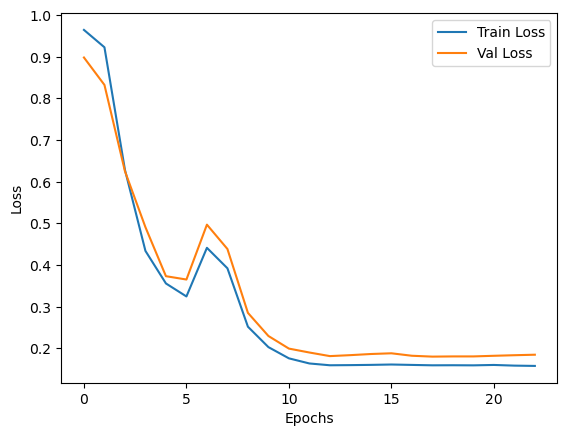

In [36]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

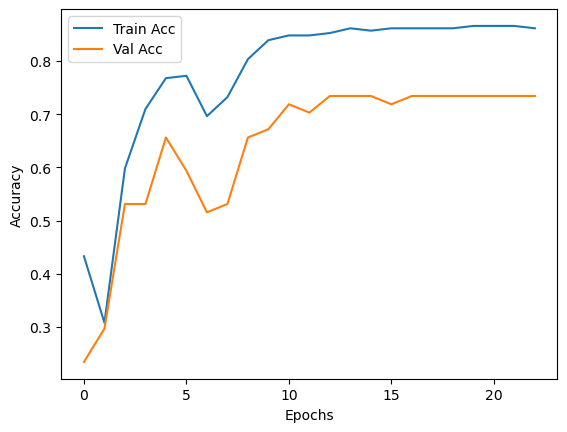

In [37]:
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [38]:
state_dict = torch.load("C://Users//DELL//Desktop//endtoend-mlops//projects//covid_chest_classification//model//best_model.pth", weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))
print(confusion_matrix(all_labels, all_preds))

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.65      0.79        20
Viral Pneumonia       0.74      1.00      0.85        20

       accuracy                           0.89        66
      macro avg       0.91      0.88      0.88        66
   weighted avg       0.92      0.89      0.89        66

[[26  0  0]
 [ 0 13  7]
 [ 0  0 20]]


In [40]:
%run grad_cam.py

In [41]:
import grad_cam
from grad_cam import generate_gradcam  
from importlib import reload

# reload to pick up latest changes
reload(grad_cam)

<module 'grad_cam' from 'c:\\Users\\DELL\\Desktop\\endtoend-mlops\\projects\\covid_chest_classification\\notebooks\\grad_cam.py'>

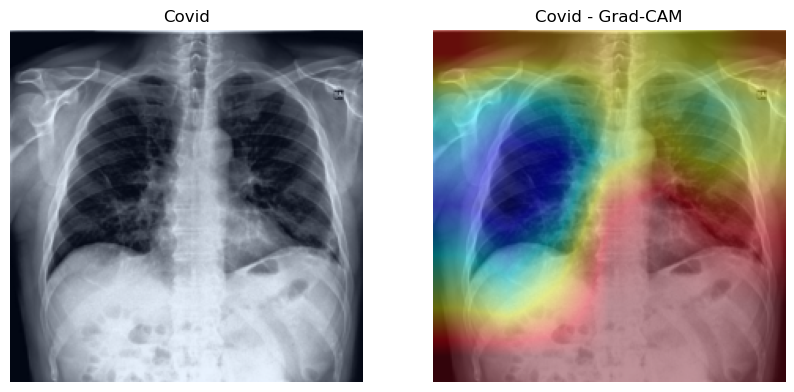

[INFO] Saved Grad-CAM comparison to gradcam_outputs\0_Covid.png


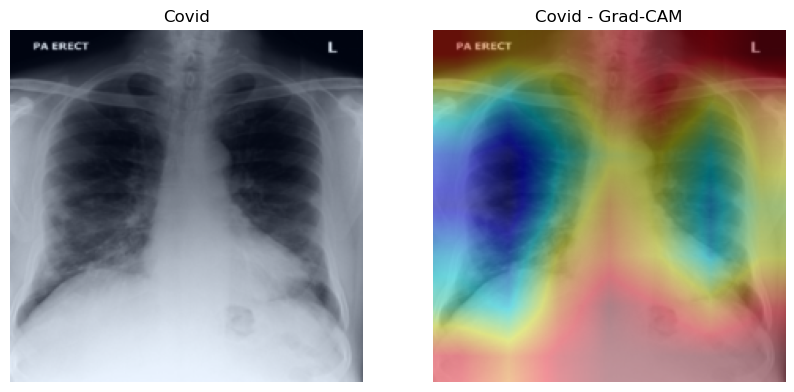

[INFO] Saved Grad-CAM comparison to gradcam_outputs\1_Covid.png


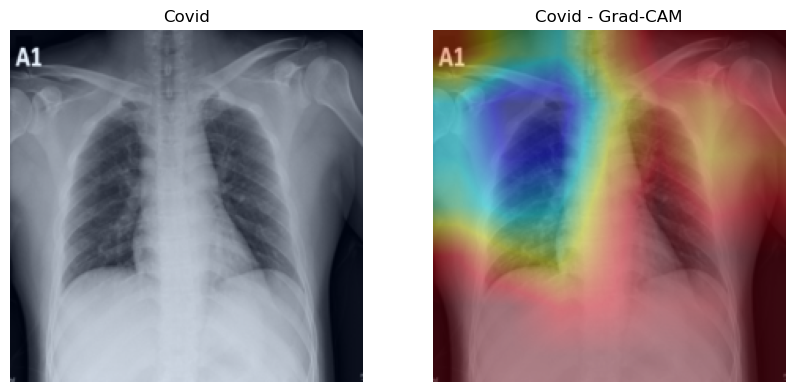

[INFO] Saved Grad-CAM comparison to gradcam_outputs\2_Covid.png


In [42]:
from grad_cam import generate_gradcam, GradCAM

# Generate Grad-CAM for first 5 images
generate_gradcam(model, test_loader, classes, save_dir="gradcam_outputs", num_images=3, device=device)